In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf 
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

In [9]:
# data
ticker = 'TSLA'
start_date = '2010-01-02'
end_date = '2021-04-25'

df = yf.download(ticker,
    start = start_date,
    end = end_date,
    progress = False)

df = df.resample('d').last()
prices = df['Adj Close'].values
prices = prices.reshape(len(prices),1)

In [14]:
prices.shape

(3952, 1)

Text(0, 0.5, 'Price ($)')

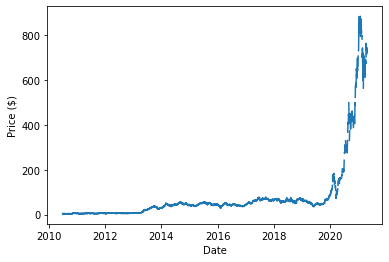

In [15]:
fig, ax = plt.subplots( )

ax.plot(df.index, prices)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

In [16]:
prices.shape

(3952, 1)

In [21]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    '''
    - data: original array
    - lookback:  How many timesteps back the input data should go
    - delay: How many timesteps in the future the target should be 
    - min_index and max_index: Indices in the data array that delimit which timesteps to draw from.
    - shuffle: Whether to shuffle the samples or draw them in chrinilogical order.
    - batch_size: The number of samples per batch.
    - step: The period, in timesteps, at which you sample data.
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

In [22]:
lookback = 22
step = 1
delay = 3
batch_size = 128

train_gen = generator(prices,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2500,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(prices,
                    lookback=lookback,
                    delay=delay,
                    min_index=2501,
                    max_index=3000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(prices,
                     lookback=lookback,
                     delay=delay,
                     min_index=3001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (3000 - 2501 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(prices) - 3001 - lookback) // batch_size

In [23]:
prices.shape[-1]

1

In [27]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, prices.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
50/50 [==============================] - 1s 5ms/step - loss: nan - val_loss: nan
Epoch 2/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 4/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 6/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 7/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 8/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 9/10
50/50 [==============================] - 0s 4ms/step - loss: nan - val_loss: nan
Epoch 10/10
50/50 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan


In [26]:
history

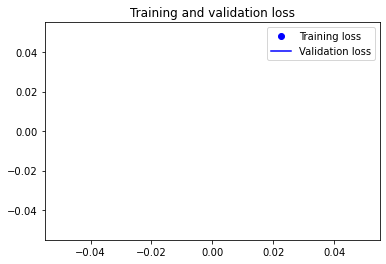

In [25]:


import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

